In [30]:
import pandas as pd
import numpy as np
from pyproj import Proj, Transformer
from concurrent import futures
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

### RivCenter csvファイルの読み込み

In [31]:
filePath = "../dat_satellite/RivCenterLine_MS_sparse.csv"
df = pd.read_csv(filePath)
print(df.head())

points = len(df) #680
print(points)

   note  flag_eleva  flag_hills         crs   latitude  flag_water  \
0   NaN  116.903226         0.0  EPSG:32616  38.284377    0.612903   
1   NaN  116.903226         0.0  EPSG:32616  38.284107    0.580645   
2   NaN  117.062500         0.0  EPSG:32616  38.283837    0.625000   
3   NaN  116.656250         0.0  EPSG:32616  38.283567    0.687500   
4   NaN  116.656250         0.0  EPSG:32616  38.283297    0.687500   

   flag_snowI  flag_cldSh  endsOverEd  orthogonal  endsInWate  flag_cloud  \
0         0.0         0.0           0    3.141593           0         0.0   
1         0.0         0.0           0    3.141593           0         0.0   
2         0.0         0.0           0    3.141593           0         0.0   
3         0.0         0.0           0    3.141593           0         0.0   
4         0.0         0.0           0    3.141593           0         0.0   

        width                                  image_id  longitude  
0  551.612903  LC08_L1TP_023033_20170915_201709

In [32]:
#領域の限定
#38.60284134429668, -90.45334533854292 38.99242639934311, -90.04685118281743
df = df.query('38.60284134429668<latitude < 38.99242639934311 & -90.45334533854292<longitude<-90.04685118281743')
df = df.reset_index()
print(df.head())
print(len(df))

   index  note  flag_eleva  flag_hills         crs   latitude  flag_water  \
0    187   NaN  128.448618         0.0  EPSG:32616  38.934342    0.452316   
1    188   NaN  128.461406         0.0  EPSG:32616  38.934352    0.495257   
2    189   NaN  128.881630         0.0  EPSG:32616  38.934362    0.495688   
3    190   NaN  128.893489         0.0  EPSG:32616  38.934372    0.538163   
4    191   NaN  129.611111         0.0  EPSG:32616  38.934381    0.444444   

   flag_snowI  flag_cldSh  endsOverEd  orthogonal  endsInWate  flag_cloud  \
0         0.0         0.0           0    1.692969           1         0.0   
1         0.0         0.0           0    1.692969           1         0.0   
2         0.0         0.0           0    1.692969           1         0.0   
3         0.0         0.0           0    1.692969           0         0.0   
4         0.0         0.0           0    1.570796           0         0.0   

        width                                  image_id  longitude  
0  24

### 方向ベクトルの定義と領域の決定

In [33]:
#lat-lonをx-yに直す
#sample code from chatGPT
projection = df["crs"][0]
projection_to_epsg3857 = Transformer.from_crs('epsg:4326', "epsg:3857")

def latlon_to_xy(lat, lon):
    # # メルカトル図法の投影座標系を定義
    # in_proj = Proj(init=projection)  # WGS 84 (緯度経度)'epsg:4326'
    # out_proj = Proj(init='epsg:3857')  # メルカトル図法（メートル単位）

    # # 緯度経度をXY座標に変換
    # x, y = transform(in_proj, out_proj, lon, lat)
    x,y = projection_to_epsg3857.transform(lat,lon)
    return x, y


In [34]:
future_list = []
with futures.ProcessPoolExecutor(os.cpu_count()) as executor:
    for lat,lon,projection in zip(df["latitude"],df["longitude"],df["crs"]):
        #x,y = latlon_to_xy(lat,lon,projection)
        future = executor.submit(latlon_to_xy,lat,lon)
        future_list.append(future)

In [35]:
x = [f.result()[0] for f in future_list]
y = [f.result()[1] for f in future_list]
points = np.array([[x0,y0] for x0,y0 in zip(x,y)])

In [36]:
print(x[0],y[0])

-10050711.69285758 4712271.054122845


### 重複する点のdrop

In [37]:
#tolerance以内にある重複する点を削除する
tolerance = 100 #m
def calculate_distance(point1, point2):
    # 二点間の距離を計算する関数
    return np.linalg.norm(point1 - point2)

def generate_sparse_set(dense_set, threshold):
    sparse_set = []
    
    for i in range(len(dense_set)):
        include_point = True
        
        for j in range(i + 1, len(dense_set)):
            distance = calculate_distance(dense_set[i], dense_set[j])
            
            if distance < threshold:
                include_point = False
                print(f"{dense_set[j]} is abundaned" )
                break
        
        if include_point:
            sparse_set.append(dense_set[i])
    
    return np.array(sparse_set)

In [ ]:
sparsePoints = generate_sparse_set(points,tolerance)

In [11]:
dist = [f.result() for f in future_list]
print(dist[:5])

[0.0, 0.0, 0.0, 0.0, 0.0]


In [15]:
def findEndPoint(num,x,y):
    """
    #find end points
    #------0-------#
    #|            |#             
    #1            3#
    #|-----2------|#
    """
    if num == 0:
        index = y.index([max(y)])
    elif num == 1:
        index = x[min(x)].index()
    elif num == 2:
        index = y.index(min(y))
    elif num == 3:
        index = x[max(x)].index()
    else:
        ValueError("Input number must be 0~3.")
    return index

In [16]:
start_index = findEndPoint(2,x,y)
print(start_index)
print(points[start_index])

679
[-1.01845686e+07  3.75423123e+01]


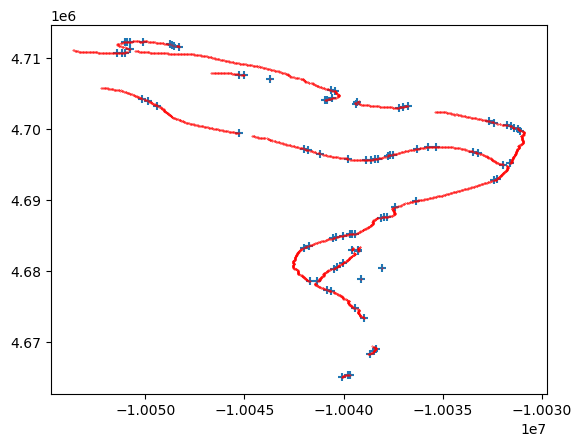

In [41]:
#check
fig,ax = plt.subplots()
ax.scatter(sparsePoints[:,0],sparsePoints[:,1],marker="+")
ax.scatter(x,y,c="r",s=0.1)
plt.show()

In [6]:
directionVectors = []


for i in range(points):
    

680


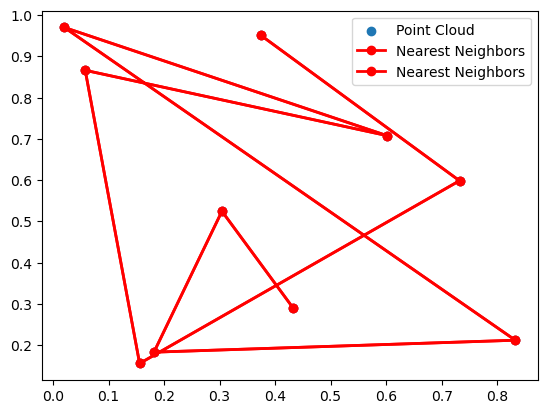

In [6]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# サンプルの点群データを生成
np.random.seed(42)
point_cloud = np.random.rand(10, 2)  # 10点の2次元点群を生成

# 最近傍点を見つけるためのNearestNeighborsモデルを構築
k_neighbors = 1  # 1つの最近傍点を見つける例
nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto').fit(point_cloud)

# 最近傍点を見つけて線をつなぐ
lines = []
for i, point in enumerate(point_cloud):
    distances, indices = nbrs.kneighbors([point])
    neighbor_index = indices[0][0]
    lines.append([point, point_cloud[neighbor_index]])

lines = np.array(lines)

# 結果の表示
plt.scatter(point_cloud[:, 0], point_cloud[:, 1], marker='o', label='Point Cloud')
plt.plot(lines[:, :, 0], lines[:, :, 1], color='red', marker='o', linestyle='-', linewidth=2, label='Nearest Neighbors')
plt.legend()
plt.show()
